In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import *
from keras.backend import tf as ktf
from keras.callbacks import EarlyStopping
from tqdm import tqdm

from keras.datasets import mnist
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import csv
%matplotlib inline

Using TensorFlow backend.


In [103]:
model.save_weights('models/bn+do+da.h5')

In [2]:
data = pd.read_csv('train.csv')
train, dev = train_test_split(data, test_size=0.25,random_state=0, stratify=data['label'])

Y_train = train.iloc[:, 0].as_matrix()
Y_train = np.eye(10, dtype='float32')[Y_train] 
#it's imp to specify dtype, as default is float64, but placeholder expects float32.
X_train = train.iloc[:,1:].as_matrix().astype('float32')
Y_dev = dev.iloc[:, 0].as_matrix()
Y_dev = np.eye(10, dtype='float32')[Y_dev]
X_dev = dev.iloc[:,1:].as_matrix().astype('float32')
X_test = pd.read_csv('test.csv').as_matrix().astype('float32')

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_dev = X_dev.reshape(X_dev.shape[0], 28, 28, 1)



print(train.shape, dev.shape)
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape)

(31500, 785) (10500, 785)
(31500, 28, 28, 1) (31500, 10)
(10500, 28, 28, 1) (10500, 10)
(28000, 28, 28, 1)


In [ ]:
# X_test = np.multiply(X_test, 1.0/255.0)
# X_train = np.multiply(X_train, 1.0/255.0)
# X_dev = np.multiply(X_dev, 1.0/255.0)

In [3]:
batch_size = 64
input_shape = (28, 28, 1)

In [4]:
gen = ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.08,
        shear_range=0.3,
        height_shift_range=0.08,
        zoom_range=0.08)

train_gen = gen.flow(X_train, Y_train, batch_size=batch_size)
dev_gen = gen.flow(X_dev, Y_dev, batch_size=batch_size)

In [5]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
def norm_input(x): return (x-mean_px)/std_px

In [6]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1,)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(' accuracy')


    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('loss')
    plt.show()

In [26]:
def getModel():
    model = Sequential()
    model.add(Lambda(norm_input, input_shape=input_shape))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [27]:
model = getModel()

In [28]:
history1 = model.fit_generator(train_gen, steps_per_epoch=train_gen.n, epochs=1, validation_data=dev_gen, validation_steps=dev_gen.n)

Epoch 1/1
31500/31500 [==============================] - 1534s 49ms/step - loss: 0.0287 - acc: 0.9907 - val_loss: 0.0298 - val_acc: 0.9923


In [29]:
model.optimizer.lr=0.1

In [30]:
history2 = model.fit_generator(train_gen, steps_per_epoch=train_gen.n, epochs=4, validation_data=dev_gen, validation_steps=dev_gen.n)

Epoch 1/4
31500/31500 [==============================] - 1550s 49ms/step - loss: 0.0102 - acc: 0.9966 - val_loss: 0.0353 - val_acc: 0.9924
Epoch 2/4
31500/31500 [==============================] - 1534s 49ms/step - loss: 0.0071 - acc: 0.9976 - val_loss: 0.0301 - val_acc: 0.9936
Epoch 3/4
31500/31500 [==============================] - 1536s 49ms/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0371 - val_acc: 0.9928
Epoch 4/4
31500/31500 [==============================] - 1529s 49ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0367 - val_acc: 0.9931


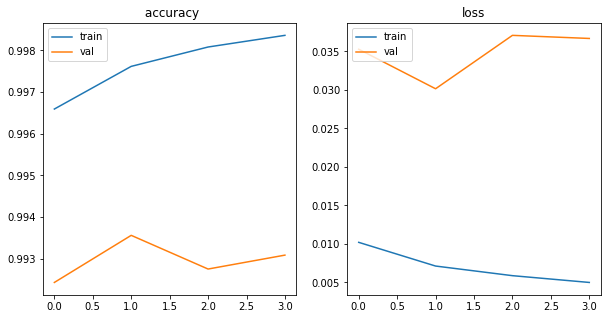

In [35]:
plot_training(history2)

In [36]:
model.optimizer.lr=0.01

In [ ]:
history3 = model.fit_generator(train_gen, steps_per_epoch=train_gen.n, epochs=12, validation_data=dev_gen, validation_steps=dev_gen.n)

Epoch 1/12
31499/31500 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9987

In [2]:
plot_training(history3)

NameError: name 'plot_training' is not defined

In [ ]:
model.optimizer.lr=0.001

In [ ]:
history4 = model.fit_generator(train_gen, steps_per_epoch=train_gen.n, epochs=1, validation_data=dev_gen, validation_steps=dev_gen.n)

In [103]:
# model.save_weights('models/bn+do+da.h5')

In [19]:
Y_predicted = np.argmax(model.predict(X_test), axis=1)

In [24]:
pred = pd.read_csv('sample_submission.csv')
pred['Label'] = Y_predicted
pred.to_csv('submission-cnn-keras-v3.csv', index=False)

## Training on whole training dataset for final submission

In [109]:
Y_data = data.iloc[:, 0].as_matrix()
Y_data = np.eye(10, dtype='float32')[Y_data] 
X_data = data.iloc[:,1:].as_matrix().astype('float32')
X_data = X_data.reshape(X_data.shape[0], 28, 28, 1)
print(X_data.shape, Y_data.shape)

(42000, 28, 28, 1) (42000, 10)


In [121]:
data_gen = gen.flow(X_data, Y_data, batch_size=32) #once I used batch_size=8, ended up with poor acc of .97

In [122]:
model = getModel()

In [115]:
# model.load_weights('models/bn+do+da.h5')

In [123]:
history5 = model.fit_generator(data_gen, steps_per_epoch=train_gen.n, epochs=1)

Epoch 1/1
31500/31500 [==============================] - 992s 31ms/step - loss: 0.0687 - acc: 0.9791


In [124]:
model.optimizer.lr=0.1

In [125]:
history5 = model.fit_generator(data_gen, steps_per_epoch=train_gen.n, epochs=4)

Epoch 1/4
31500/31500 [==============================] - 931s 30ms/step - loss: 0.0304 - acc: 0.9906
Epoch 2/4
31500/31500 [==============================] - 745s 24ms/step - loss: 0.0236 - acc: 0.9926
Epoch 3/4
31500/31500 [==============================] - 669s 21ms/step - loss: 0.0196 - acc: 0.9939
Epoch 4/4
31500/31500 [==============================] - 639s 20ms/step - loss: 0.0172 - acc: 0.9947


In [126]:
model.optimizer.lr=0.01

In [127]:
history6 = model.fit_generator(data_gen, steps_per_epoch=train_gen.n, epochs=12)

Epoch 1/12
31500/31500 [==============================] - 635s 20ms/step - loss: 0.0158 - acc: 0.9951
Epoch 2/12
31500/31500 [==============================] - 636s 20ms/step - loss: 0.0145 - acc: 0.9955
Epoch 3/12
31500/31500 [==============================] - 655s 21ms/step - loss: 0.0135 - acc: 0.9958
Epoch 4/12
31500/31500 [==============================] - 635s 20ms/step - loss: 0.0129 - acc: 0.9960
Epoch 5/12
31500/31500 [==============================] - 632s 20ms/step - loss: 0.0120 - acc: 0.9962
Epoch 6/12
31500/31500 [==============================] - 636s 20ms/step - loss: 0.0118 - acc: 0.9964
Epoch 7/12
31500/31500 [==============================] - 627s 20ms/step - loss: 0.0112 - acc: 0.9965
Epoch 8/12
31500/31500 [==============================] - 671s 21ms/step - loss: 0.0109 - acc: 0.9966
Epoch 9/12
31500/31500 [==============================] - 691s 22ms/step - loss: 0.0107 - acc: 0.9967
Epoch 10/12
31500/31500 [==============================] - 691s 22ms/step - loss: 

In [128]:
model.optimizer.lr=0.001

In [129]:
history7 = model.fit_generator(data_gen, steps_per_epoch=train_gen.n, epochs=1)

Epoch 1/1
31500/31500 [==============================] - 682s 22ms/step - loss: 0.0094 - acc: 0.9971


In [132]:
Y_predicted = model.predict(X_test, verbose=1)

28000/28000 [==============================] - 4s 152us/step


In [142]:
pred = pd.read_csv('sample_submission.csv')
pred['Label'] = np.argmax(Y_predicted, axis=1)
pred.to_csv('submission-cnn-keras-v2.csv', index=False)